# Proyek Klasifikasi Gambar: Penyakit Alzheimer
- **Nama:** Hanna Safira Choirunisa
- **Email:** hannaaasc@gmail.com
- **ID Dicoding:** MC008D5X2353

**Objektif**  <br>

Membangun model CNN yang dapat mengklasifikasikan Penyakit Alzheimer ke dalam empat kategori berdasarkan pemindaian otak MRI. Keempat kategori tersebut adalah:  
1. Penyakit Alzheimer (Alzheimer's Disease/AD)  
2. Normal Kognitif (Cognitively Normal/CN)  
3. Gangguan Kognitif Ringan Awal (Early Mild Cognitive Impairment/EMCI)  
4. Gangguan Kognitif Ringan Akhir (Late Mild Cognitive Impairment/LMCI)

**Sumber Dataset**  <br>
Link: https://www.kaggle.com/datasets/abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset

## Import Semua Packages/Library yang Digunakan

In [ ]:
# pip install tensorflowjs

In [2]:
# Mengimpor libraries umum yang sering digunakan
import os
import shutil
import sys
import zipfile
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
from PIL import ImageFilter
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import tensorflowjs as tfjs

# Mengabaikan peringatan
import warnings
warnings.filterwarnings("ignore")


# Set semua seed untuk reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## **Data Preparation**

### **Data Loading**

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hannaaasc","key":"a79520d8671cda275715dea02256776e"}'}

In [4]:
# Buat folder .kaggle jika belum ada
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

# Memindahkan file kaggle.json ke folder yang benar
shutil.move('/content/kaggle.json', '/root/.kaggle/kaggle.json')

# Mengatur hak akses file untuk keamanan
os.chmod('/root/.kaggle/kaggle.json', 0o600)

In [5]:
!kaggle datasets download -d abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset
!unzip adni-4c-alzheimers-mri-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: AugmentedAlzheimerDataset/LMCI/704dcd6c-b988-4221-8f70-f528992aee88.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/705f871d-d4dd-4ccb-a713-d20724fe2f17.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/7069c7cf-f4db-4c97-9c80-db7f3abd0643.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/70743509-c035-4392-b5a5-a35687c4ae67.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/707c8044-826c-410c-abf7-0355d770e966.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/707d3e15-7d33-44e2-8172-906ccff06a36.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/70804c51-b847-49e4-9cb0-73800c71b079.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/7082349e-7033-4ecd-99dd-2ed5f107e4cf.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/7083fd14-8b23-4212-93a0-97d285d6236d.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/708ca1d2-4e2e-45aa-8f72-4bc96a700007.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/70924e6b-dffc-4ebc-be4c-e82b1279c0f

Jumlah data tiap kategori

In [6]:
# Path ke direktori dataset
directory = 'AugmentedAlzheimerDataset'

In [7]:
# Fungsi untuk menampilkan resolusi unik tiap kategori (subdirectory)
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [8]:
print_images_resolution(directory)

AD: 8960
- (180, 180)
- (200, 190)
---------------
LMCI: 8960
- (180, 180)
- (200, 190)
---------------
.tmp.driveupload: 11756
- (180, 180)
- (200, 190)
---------------
CN: 6464
- (180, 180)
- (200, 190)
---------------
EMCI: 9600
- (180, 180)
- (200, 190)
---------------

Total: 45740


Dataset gambar terdiri dari 2 macam ukuran/resolusi, yaitu 180x180 dan 200x190.

In [9]:
# Path ke folder .tmp.driveupload
tmp_dir = os.path.join(directory, '.tmp.driveupload')

# Mengecek jika folder .tmp.driveupload ada, lalu menghapusnya
if os.path.exists(tmp_dir) and os.path.isdir(tmp_dir):
    shutil.rmtree(tmp_dir)  # Menghapus folder beserta isinya
    print(f"Folder {tmp_dir} telah dihapus.")
else:
    print(f"Folder {tmp_dir} tidak ditemukan.")

Folder AugmentedAlzheimerDataset/.tmp.driveupload telah dihapus.


In [10]:
# cek kembali
print_images_resolution(directory)

AD: 8960
- (180, 180)
- (200, 190)
---------------
LMCI: 8960
- (180, 180)
- (200, 190)
---------------
CN: 6464
- (180, 180)
- (200, 190)
---------------
EMCI: 9600
- (180, 180)
- (200, 190)
---------------

Total: 33984


Folder AugmentedAlzheimerDataset/.tmp.driveupload benar-benar sudah terhapus.

### **Exploratory Data Analysis**

#### 5 Gambar acak tiap kategori

In [11]:
# Fungsi untuk menampilkan 5 gambar acak dari tiap kategori
def display_random_images(directory, num_images=5):
    # Mengecek apakah direktori ada
    if not os.path.exists(directory):
        print(f"Direktori {directory} tidak ditemukan.")
        return

    # Menelusuri subdirektori dalam dataset
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        # Mengecek apakah subdirektori benar-benar ada dan folder
        if os.path.isdir(subdir_path):
            image_files = os.listdir(subdir_path)
            random_images = random.sample(image_files, min(num_images, len(image_files)))  # Mengambil gambar acak

            # Menampilkan gambar acak
            fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
            for i, img_file in enumerate(random_images):
                img_path = os.path.join(subdir_path, img_file)
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].axis('off')  # Menyembunyikan axis
                axes[i].set_title(f"{subdir}")
            plt.show()

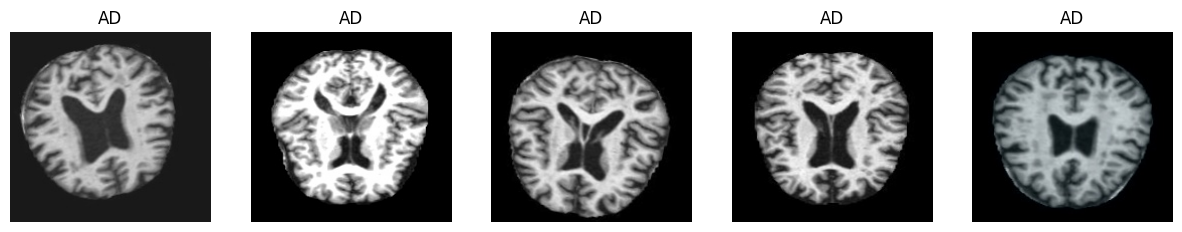

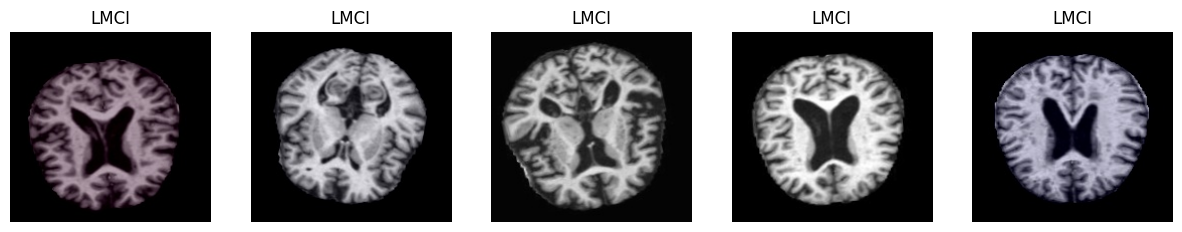

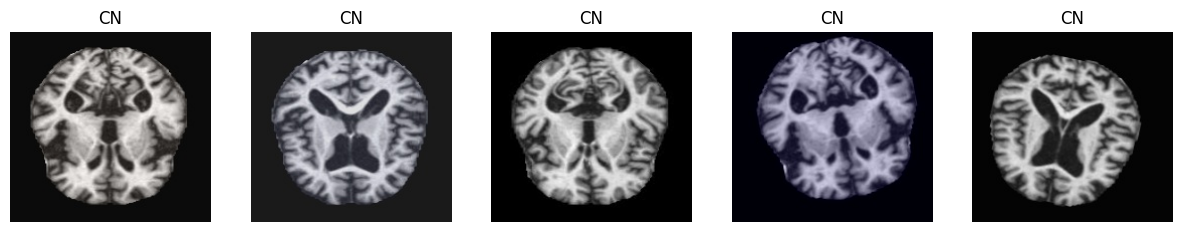

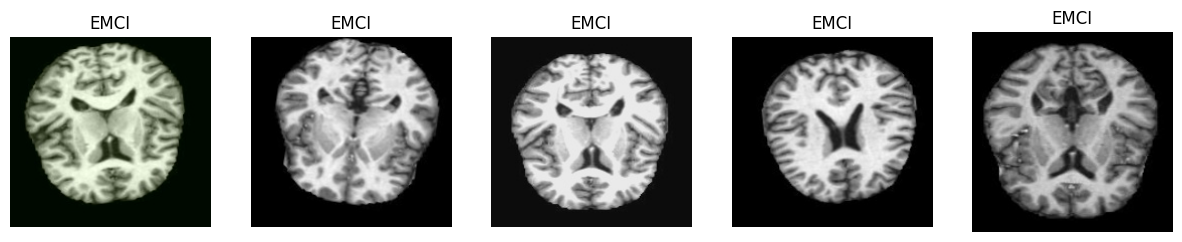

In [12]:
# Menampilkan 5 gambar acak dari setiap kategori
display_random_images(directory, num_images=5)

#### Distribusi frekuensi tiap kategori

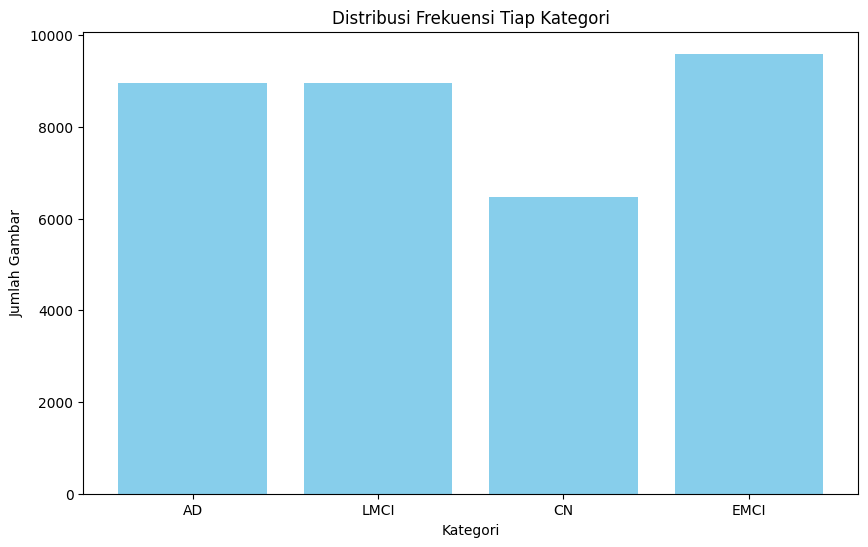

In [13]:
categories = []
image_counts = []

# Menelusuri subdirektori dalam dataset
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)

    # Mengecek apakah subdirektori benar-benar ada dan folder
    if os.path.isdir(subdir_path):
          image_files = os.listdir(subdir_path)
          categories.append(subdir)
          image_counts.append(len(image_files))

# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, image_counts, color='skyblue')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Frekuensi Tiap Kategori')
plt.show()

### **Data Preprocessing**

#### Split Dataset

In [14]:
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(directory):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
AD,8960
CN,6464
EMCI,9600
LMCI,8960


In [15]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Membuat DataFrame untuk train, validation, dan test set
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [17]:
# Menampilkan ukuran masing-masing set
print('Train size:', len(df_tr))
print('Test size:', len(df_te))

Train size: 27187
Test size: 6797


In [18]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   AD        1792
       CN        1293
       EMCI      1920
       LMCI      1792
train  AD        7168
       CN        5171
       EMCI      7680
       LMCI      7168
dtype: int64 


                                                    path labels    set
16224  AugmentedAlzheimerDataset/AD/f949596f-b9c2-4ca...     AD  train
1188   AugmentedAlzheimerDataset/CN/8ce14f09-2820-443...     CN  train
21512  AugmentedAlzheimerDataset/LMCI/7d009ea6-4299-4...   LMCI  train
2111   AugmentedAlzheimerDataset/EMCI/f7f09a2a-8604-4...   EMCI  train
12968  AugmentedAlzheimerDataset/AD/6ce34f0e-96d5-49a...     AD  train


In [19]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "AugmentedAlzheimerDataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [20]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [21]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_AD = os.path.join(TRAIN_DIR + '/AD')
train_CN = os.path.join(TRAIN_DIR + '/CN')
train_EMCI = os.path.join(TRAIN_DIR + '/EMCI')
train_LMCI = os.path.join(TRAIN_DIR + '/LMCI')

test_AD = os.path.join(TEST_DIR + '/AD')
test_CN = os.path.join(TEST_DIR + '/CN')
test_EMCI = os.path.join(TEST_DIR + '/EMCI')
test_LMCI = os.path.join(TEST_DIR + '/LMCI')

print("Total number of AD images in training set: ", len(os.listdir(train_AD)))
print("Total number of CN images in training set: ", len(os.listdir(train_CN)))
print("Total number of EMCI images in training set: ", len(os.listdir(train_EMCI)))
print("Total number of LMCI images in training set: ", len(os.listdir(train_LMCI)))

print("\nTotal number of AD images in test set: ", len(os.listdir(test_AD)))
print("Total number of CN images in test set: ", len(os.listdir(test_CN)))
print("Total number of EMCI images in test set: ", len(os.listdir(test_EMCI)))
print("Total number of LMCI images in test set: ", len(os.listdir(test_LMCI)))

Total number of AD images in training set:  7168
Total number of CN images in training set:  5171
Total number of EMCI images in training set:  7680
Total number of LMCI images in training set:  7168

Total number of AD images in test set:  1792
Total number of CN images in test set:  1293
Total number of EMCI images in test set:  1920
Total number of LMCI images in test set:  1792


#### Image Data Generator

In [22]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2,  # 20% untuk validasi
    rotation_range=40,  # Rotasi acak
    width_shift_range=0.2,  # Pergeseran horizontal acak
    height_shift_range=0.2,  # Pergeseran vertikal acak
    shear_range=0.2,  # Pemotongan acak
    zoom_range=0.2,  # Zoom acak
    horizontal_flip=True,  # Pembalikan horizontal
    fill_mode='nearest'  # Penanganan piksel yang hilang
)

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 21751 images belonging to 4 classes.
Found 5436 images belonging to 4 classes.
Found 6797 images belonging to 4 classes.


## **Modelling**

In [24]:
# Base model (pre-trained model)
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Fine tune
base_model.trainable = True

fine_tune_at = 100

# Bekukan lapisan sebelum lapisan ke-100, agar hanya lapisan setelahnya yang dilatih
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create Sequential model
model = Sequential()

# Add base model as a feature extractor
model.add(base_model)

# Add custom layers on top of the base model
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer with softmax for multi-class classification
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [25]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 5, 5, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       516,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,225,283 (69.52 MB)

 Trainable params: 18,013,316 (68.72 MB)

 Non-trainable params: 211,967 (828.00 KB)

In [26]:
# Menghitung jumlah gambar untuk setiap kelas
count_AD = len(os.listdir(train_AD))
count_CN = len(os.listdir(train_CN))
count_EMCI = len(os.listdir(train_EMCI))
count_LMCI = len(os.listdir(train_LMCI))

# Menentukan total jumlah gambar
total_images = count_AD + count_CN + count_EMCI + count_LMCI

# Menghitung class weights berdasarkan jumlah gambar per kelas
weight_AD = total_images / (4 * count_AD)
weight_CN = total_images / (4 * count_CN)
weight_EMCI = total_images / (4 * count_EMCI)
weight_LMCI = total_images / (4 * count_LMCI)

# Membuat dictionary class_weights
class_weights = {
    0: weight_AD,
    1: weight_CN,
    2: weight_EMCI,
    3: weight_LMCI
}

print("Class weights: ", class_weights)

Class weights:  {0: 0.9482073102678571, 1: 1.3143976020112165, 2: 0.8849934895833333, 3: 0.9482073102678571}


In [27]:
# Callback
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True  # Mengembalikan bobot model ke titik terbaik
)

# Model checkpoint
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,  # Menyimpan hanya model dengan performance terbaik
    verbose=1
)

In [28]:
%time

# Training model dengan callbacks
hist = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint]
)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.2865 - loss: 1.3911
Epoch 1: val_loss improved from inf to 1.11875, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 411s 522ms/step - accuracy: 0.2866 - loss: 1.3910 - val_accuracy: 0.4766 - val_loss: 1.1188
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4778 - loss: 1.0924
Epoch 2: val_loss improved from 1.11875 to 0.91185, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 373s 515ms/step - accuracy: 0.4779 - loss: 1.0923 - val_accuracy: 0.6032 - val_loss: 0.9119
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5653 - loss: 0.8863
Epoch 3: val_loss improved from 0.91185 to 0.71668, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 415s 564ms/step - accuracy: 0.5653 - loss: 0.8862 - val_accuracy: 0.6599 - val_loss: 0.7167
Epoch 4/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6129 - loss: 0.7871
Epoch 4: val_loss improved from 0.71668 to 0.67678, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 383s 563ms/step - accuracy: 0.6129 - loss: 0.7870 - val_accuracy: 0.6876 - val_loss: 0.6768
Epoch 5/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6372 - loss: 0.7270
Epoch 5: val_loss improved from 0.67678 to 0.63263, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 410s 516ms/step - accuracy: 0.6372 - loss: 0.7270 - val_accuracy: 0.7112 - val_loss: 0.6326
Epoch 6/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6829 - loss: 0.6646
Epoch 6: val_loss improved from 0.63263 to 0.62457, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 400s 588ms/step - accuracy: 0.6829 - loss: 0.6645 - val_accuracy: 0.7143 - val_loss: 0.6246
Epoch 7/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7033 - loss: 0.6167
Epoch 7: val_loss improved from 0.62457 to 0.51980, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 411s 542ms/step - accuracy: 0.7033 - loss: 0.6167 - val_accuracy: 0.7662 - val_loss: 0.5198
Epoch 8/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7358 - loss: 0.5638
Epoch 8: val_loss improved from 0.51980 to 0.44175, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 406s 578ms/step - accuracy: 0.7358 - loss: 0.5638 - val_accuracy: 0.7995 - val_loss: 0.4418
Epoch 9/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7576 - loss: 0.5297
Epoch 9: val_loss did not improve from 0.44175
680/680 ━━━━━━━━━━━━━━━━━━━━ 350s 515ms/step - accuracy: 0.7576 - loss: 0.5297 - val_accuracy: 0.7901 - val_loss: 0.4977
Epoch 10/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7894 - loss: 0.4681
Epoch 10: val_loss improved from 0.44175 to 0.38649, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 386s 568ms/step - accuracy: 0.7894 - loss: 0.4680 - val_accuracy: 0.8440 - val_loss: 0.3865
Epoch 11/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8053 - loss: 0.4357
Epoch 11: val_loss did not improve from 0.38649
680/680 ━━━━━━━━━━━━━━━━━━━━ 349s 512ms/step - accuracy: 0.8053 - loss: 0.4357 - val_accuracy: 0.8464 - val_loss: 0.3868
Epoch 12/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8316 - loss: 0.3871
Epoch 12: val_loss improved from 0.38649 to 0.32323, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 382s 512ms/step - accuracy: 0.8316 - loss: 0.3871 - val_accuracy: 0.8624 - val_loss: 0.3232
Epoch 13/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8474 - loss: 0.3683
Epoch 13: val_loss improved from 0.32323 to 0.27247, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 348s 512ms/step - accuracy: 0.8474 - loss: 0.3683 - val_accuracy: 0.8870 - val_loss: 0.2725
Epoch 14/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8634 - loss: 0.3327
Epoch 14: val_loss improved from 0.27247 to 0.25377, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 418s 565ms/step - accuracy: 0.8634 - loss: 0.3327 - val_accuracy: 0.9100 - val_loss: 0.2538
Epoch 15/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8759 - loss: 0.3062
Epoch 15: val_loss improved from 0.25377 to 0.24703, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 440s 563ms/step - accuracy: 0.8759 - loss: 0.3061 - val_accuracy: 0.9051 - val_loss: 0.2470
Epoch 16/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8845 - loss: 0.2822
Epoch 16: val_loss improved from 0.24703 to 0.19137, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 345s 508ms/step - accuracy: 0.8845 - loss: 0.2822 - val_accuracy: 0.9314 - val_loss: 0.1914
Epoch 17/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8948 - loss: 0.2626
Epoch 17: val_loss improved from 0.19137 to 0.17777, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 385s 512ms/step - accuracy: 0.8948 - loss: 0.2626 - val_accuracy: 0.9283 - val_loss: 0.1778
Epoch 18/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9074 - loss: 0.2399
Epoch 18: val_loss did not improve from 0.17777
680/680 ━━━━━━━━━━━━━━━━━━━━ 347s 511ms/step - accuracy: 0.9074 - loss: 0.2399 - val_accuracy: 0.9244 - val_loss: 0.2055
Epoch 19/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9139 - loss: 0.2228
Epoch 19: val_loss did not improve from 0.17777
680/680 ━━━━━━━━━━━━━━━━━━━━ 418s 564ms/step - accuracy: 0.9139 - loss: 0.2228 - val_accuracy: 0.9395 - val_loss: 0.1946
Epoch 20/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9166 - loss: 0.2098
Epoch 20: val_loss improved from 0.17777 to 0.14280, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 349s 513ms/step - accuracy: 0.9166 - loss: 0.2098 - val_accuracy: 0.9490 - val_loss: 0.1428
Epoch 21/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9248 - loss: 0.1968
Epoch 21: val_loss did not improve from 0.14280
680/680 ━━━━━━━━━━━━━━━━━━━━ 347s 511ms/step - accuracy: 0.9248 - loss: 0.1968 - val_accuracy: 0.9547 - val_loss: 0.1527
Epoch 22/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9307 - loss: 0.1915
Epoch 22: val_loss did not improve from 0.14280
680/680 ━━━━━━━━━━━━━━━━━━━━ 431s 583ms/step - accuracy: 0.9307 - loss: 0.1915 - val_accuracy: 0.9529 - val_loss: 0.1576
Epoch 23/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9355 - loss: 0.1750
Epoch 23: val_loss improved from 0.14280 to 0.12410, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 361s 530ms/step - accuracy: 0.9355 - loss: 0.1750 - val_accuracy: 0.9592 - val_loss: 0.1241
Epoch 24/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9401 - loss: 0.1728
Epoch 24: val_loss did not improve from 0.12410
680/680 ━━━━━━━━━━━━━━━━━━━━ 408s 569ms/step - accuracy: 0.9401 - loss: 0.1728 - val_accuracy: 0.9687 - val_loss: 0.5525
Epoch 25/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9410 - loss: 0.1662
Epoch 25: val_loss did not improve from 0.12410
680/680 ━━━━━━━━━━━━━━━━━━━━ 439s 565ms/step - accuracy: 0.9410 - loss: 0.1662 - val_accuracy: 0.9616 - val_loss: 0.2379
Epoch 26/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9479 - loss: 0.1555
Epoch 26: val_loss improved from 0.12410 to 0.10390, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 408s 515ms/step - accuracy: 0.9479 - loss: 0.1555 - val_accuracy: 0.9623 - val_loss: 0.1039
Epoch 27/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9476 - loss: 0.1611
Epoch 27: val_loss improved from 0.10390 to 0.06773, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 415s 564ms/step - accuracy: 0.9476 - loss: 0.1611 - val_accuracy: 0.9783 - val_loss: 0.0677
Epoch 28/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9511 - loss: 0.1487
Epoch 28: val_loss did not improve from 0.06773
680/680 ━━━━━━━━━━━━━━━━━━━━ 382s 562ms/step - accuracy: 0.9511 - loss: 0.1487 - val_accuracy: 0.9676 - val_loss: 0.1522
Epoch 29/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9520 - loss: 0.1358
Epoch 29: val_loss improved from 0.06773 to 0.06662, saving model to best_model.h5


680/680 ━━━━━━━━━━━━━━━━━━━━ 384s 564ms/step - accuracy: 0.9520 - loss: 0.1358 - val_accuracy: 0.9770 - val_loss: 0.0666
Epoch 30/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9550 - loss: 0.1356
Epoch 30: val_loss did not improve from 0.06662
680/680 ━━━━━━━━━━━━━━━━━━━━ 385s 566ms/step - accuracy: 0.9550 - loss: 0.1356 - val_accuracy: 0.9713 - val_loss: 0.1105
Restoring model weights from the end of the best epoch: 29.


Diperoleh akurasi terbaik dari data training dan validation pada epoch ke 29, yaitu sebesar 0.952 (95.2%) dan 0.977 (97.7%)

## **Evaluasi dan Visualisasi**

In [29]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

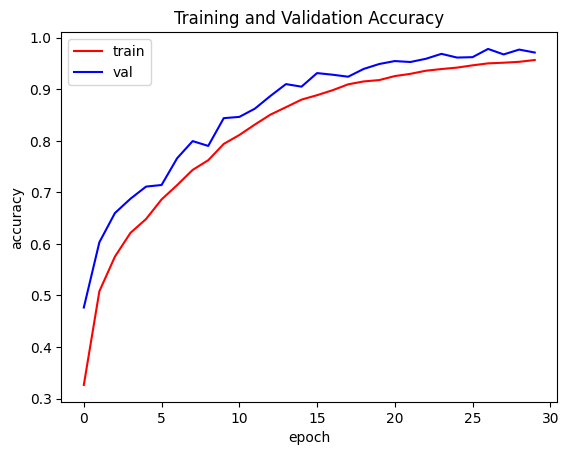

In [30]:
# plot akurasi
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

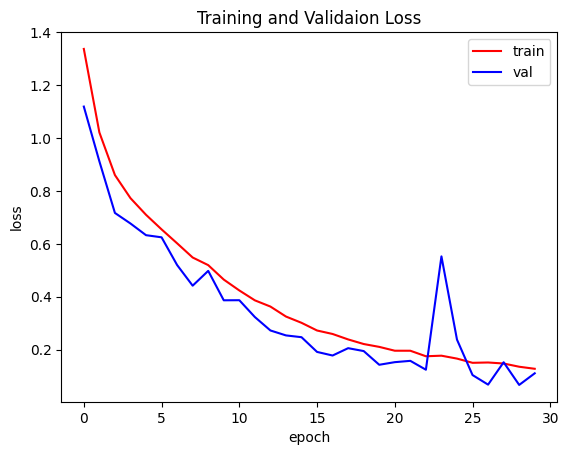

In [31]:
# plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.title('Training and Validaion Loss')
plt.show()

### Evaluasi data test

In [36]:
test_generator.reset()

# Prediksi menggunakan model
test_preds = model.predict(test_generator, verbose=0)

# Mengubah prediksi menjadi kelas dengan probabilitas tertinggi
test_preds = np.argmax(test_preds, axis=1)

In [37]:
# Mendapatkan urutan class_names untuk data test
test_class_names = list(test_generator.class_indices.keys())
print("Test Class Names:", test_class_names)

Test Class Names: ['AD', 'CN', 'EMCI', 'LMCI']


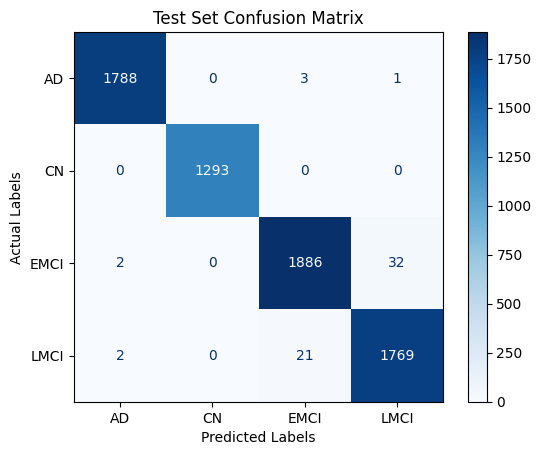

In [38]:
# Confusion Matrix
test_cm = confusion_matrix(test_generator.classes, test_preds)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=test_class_names)
test_disp.plot(cmap='Blues', values_format='d')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [39]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(test_generator.classes, test_preds, target_names=test_class_names, digits=3))


Classification Report:

              precision    recall  f1-score   support

          AD      0.998     0.998     0.998      1792
          CN      1.000     1.000     1.000      1293
        EMCI      0.987     0.982     0.985      1920
        LMCI      0.982     0.987     0.984      1792

    accuracy                          0.991      6797
   macro avg      0.992     0.992     0.992      6797
weighted avg      0.991     0.991     0.991      6797



Diperoleh akurasi pada data test sebesar 0.991 (99.1%)

## **Konversi Model**

### SavedModel

In [ ]:
# Tentukan path untuk menyimpan model
saved_model_path = '/content/model/saved_model/'

# Simpan model ke format SavedModel
tf.saved_model.save(model, saved_model_path)

### TFLite

In [41]:
# Path untuk menyimpan model TFLite
tflite_model_path = '/content/model/tflite/'

# Membuat folder jika belum ada
os.makedirs(tflite_model_path, exist_ok=True)

# Menyembunyikan output
sys.stdout = open(os.devnull, 'w')

# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model ke format TFLite
with open(os.path.join(tflite_model_path, "model.tflite"), "wb") as f:
    f.write(tflite_model)

sys.stdout = sys.__stdout__

In [42]:
# Membuat file label.txt
labels = test_class_names

label_txt_path = '/content/model/tflite/label.txt'
with open(label_txt_path, 'w') as label_file:
    for label in labels:
        label_file.write(f"{label}\n")

### TensorFlow.js

In [43]:
# Path untuk menyimpan model TF.js
tfjs_model_path = '/content/model/tfjs_model/'

# Menyimpan model ke format TF.js
tfjs.converters.save_keras_model(model, tfjs_model_path)

## **Inference**

In [64]:
from google.colab import files

# Upload file gambar
uploaded = files.upload()

Data gambar yang digunakan diperoleh dari https://link.springer.com/article/10.1007/s42979-023-02461-1. Data gambar merupakan pemindaian otak MRI dari pasien pengidap EMCI.

### SavedModel

In [45]:
# Memuat SavedModel
saved_model_path = '/content/model/saved_model/'
s_model = tf.saved_model.load(saved_model_path)

# Akses fungsi inferensi dari SavedModel
infer = s_model.signatures["serving_default"]

In [46]:
print(f"Signature input keys: {infer.structured_input_signature}")
print(f"Signature output keys: {infer.structured_outputs}")

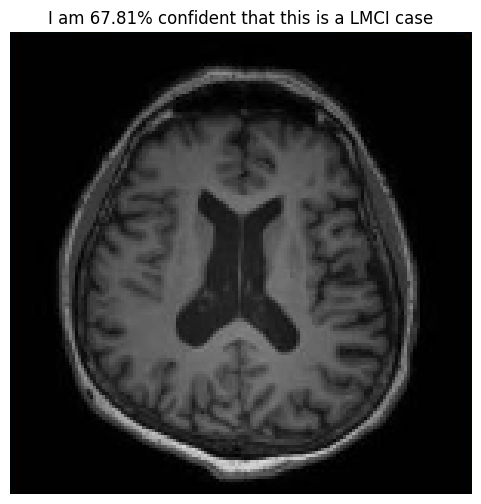

In [65]:
for fn in uploaded.keys():
    # Memuat gambar yang di-upload
    test_img = image.load_img(fn, target_size=(150, 150), color_mode='rgb')

    # Preprocessing gambar
    pp_test_img = image.img_to_array(test_img)
    pp_test_img = pp_test_img / 255  # Normalisasi

    # Menyiapkan input untuk model dengan nama 'inputs'
    input_tensor = tf.convert_to_tensor(pp_test_img, dtype=tf.float32)

    # Prediksi menggunakan model
    preds = infer(inputs=input_tensor)  # Menjalankan inference dengan input bernama 'inputs'

    # Mengambil hasil prediksi (probabilitas)
    pred_probs = preds["output_0"]  # Sesuaikan dengan nama output signature model
    predicted_class = np.argmax(pred_probs, axis=1)[0]
    class_names = ['AD', 'CN', 'EMCI', 'LMCI']

    # Menampilkan hasil prediksi
    plt.figure(figsize=(6,6))
    plt.axis('off')

    # Menampilkan label prediksi
    out = f"I am {pred_probs[0][predicted_class]*100:.2f}% confident that this is a {class_names[predicted_class]} case"
    plt.title(out)
    plt.imshow(np.squeeze(pp_test_img))
    plt.show()

### TFLite

In [48]:
# Memuat model TFLite
tflite_model_path = '/content/model/tflite/model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Fungsi untuk melakukan prediksi menggunakan TFLite
def predict_with_tflite(interpreter, test_img):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocessing gambar
    input_data = np.expand_dims(test_img, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

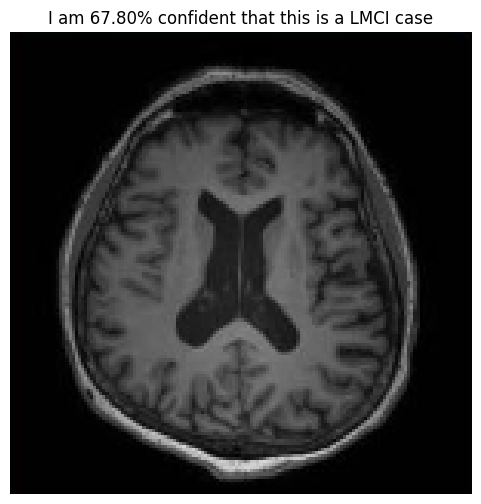

In [66]:
for fn in uploaded.keys():
    # Memuat gambar yang di-upload
    test_img = image.load_img(fn, target_size=(150, 150), color_mode='rgb')

    # Preprocessing gambar
    pp_test_img = image.img_to_array(test_img)
    pp_test_img = pp_test_img / 255  # Normalisasi

    # Prediksi menggunakan TFLite
    preds = predict_with_tflite(interpreter, pp_test_img)

    # Menampilkan hasil prediksi
    plt.figure(figsize=(6,6))
    plt.axis('off')

    # Mengambil kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(preds, axis=1)[0]
    class_names = ['AD', 'CN', 'EMCI', 'LMCI']

    # Menampilkan label prediksi
    out = f"I am {preds[0][predicted_class]*100:.2f}% confident that this is a {class_names[predicted_class]} case"
    plt.title(out)
    plt.imshow(np.squeeze(pp_test_img))
    plt.show()


Model memprediksi dengan 67,80% yakin bahwa ini adalah kasus LMCI (Gangguan Kognitif Ringan Akhir). Meskipun demikian, gambar tersebut sebenarnya berasal dari pasien dengan EMCI (Gangguan Kognitif Ringan Awal). Perbedaan ini mungkin disebabkan oleh keterbatasan model dalam membedakan dengan akurat antara kedua tahap gangguan kognitif tersebut, yang memiliki ciri-ciri visual yang sangat mirip pada pemindaian otak. Ini menunjukkan bahwa model perlu diperbaiki dengan data yang lebih representatif atau lebih banyak variasi untuk meningkatkan kemampuan klasifikasinya.

## **Download file yang dibutuhkan**

#### 1. Model yang disimpan dalam SavedModel, TFLite, dan TensorFlow.js

In [50]:
from google.colab import files

# Path folder yang ingin di-zip
folder_path = '/content/model'

# Path file zip yang akan dibuat
zip_file_path = '/content/model.zip'

# Membuat file zip dari folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

# Mendownload file zip
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2. best_model.h5

In [53]:
from google.colab import files

# Path best_model
file_path = '/content/best_model.h5'

files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 3. requirements.txt

In [67]:
!pip freeze > requirements.txt

In [68]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>